In [1]:
from PIL import Image
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [5]:
DATASET_DIR = 'data/images'

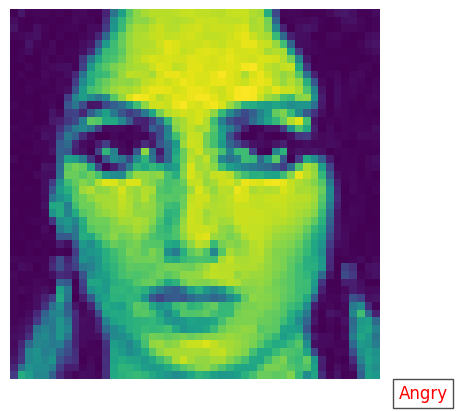

In [8]:
def load_image_tensor(filepath):
    img = Image.open(filepath)
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(img)

    return img_tensor

img = load_image_tensor(f"{DATASET_DIR}/train/angry/3905.jpg").reshape(48, 48)
plt.imshow(img,cmap="gray")

plt.imshow(img)
plt.axis('off')
plt.text(50, 50, "Angry", color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.show()


In [9]:
Image_list = []
Label_list = []
label_dic = {"angry":0, "disgust":1, "fear":2, "happy":3, "neutral":4, "sad":5, "surprise":6,}
for folder in os.listdir(DATASET_DIR):
    for label in os.listdir(f"{DATASET_DIR}/"+folder):
        for image in os.listdir(f"{DATASET_DIR}/"+folder+"/"+label):
            Image_list.append(f"{DATASET_DIR}/"+folder+"/"+label+"/"+image)
            Label_list.append(label_dic[label])

Image_df = pd.DataFrame(Image_list,columns=["Image Path"])
Label_df = pd.DataFrame(Label_list,columns=["Label"])
Dataset_df = pd.concat([Image_df,Label_df],axis=1)

In [10]:
from torch.utils.data import Dataset

class FERDataset(Dataset):
    def __init__(self, dataset_df):
        super().__init__()
        # self.dataframe = dataset_df[:35880]
        self.dataframe = dataset_df

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, i):
        return self.dataframe.iloc[i]

In [14]:
import multiprocessing as mp
from torch.utils.data import DataLoader, random_split

def custom_collate_fn(batch):
    image_batch_tensor = torch.FloatTensor(len(batch), 48, 48)
    image_tensors = []
    labels = []
    for item in batch:
        image_tensor = load_image_tensor(item.iloc[0])
        image_tensors.append(image_tensor)
        labels.append(item.iloc[1])

    torch.cat(image_tensors, out=image_batch_tensor)
    label_batch_tensor = torch.LongTensor(labels)
    return (image_batch_tensor, label_batch_tensor)


def load_data(dataset_df, batch_sz=100, train_val_test_split=[0.3, 0.2, 0.5]):

    assert sum(train_val_test_split) == 1, "Train, val and test fractions should sum to 1!"
    dataset = FERDataset(dataset_df)

    tr_va_te = []
    for frac in train_val_test_split:
        actual_count = frac * len(dataset)
        actual_count = round(actual_count)
        tr_va_te.append(actual_count)

    # split dataset into train, val and test
    train_split, val_split, test_split = random_split(dataset, tr_va_te)


    n_cpus = mp.cpu_count()
    train_dl = DataLoader(train_split,
                          batch_size=batch_sz,
                          shuffle=True,
                          collate_fn=custom_collate_fn,
                          num_workers=n_cpus)
    val_dl = DataLoader(val_split,
                        batch_size=batch_sz,
                        shuffle=True,
                        collate_fn=custom_collate_fn,
                        num_workers=n_cpus)
    test_dl = DataLoader(test_split,
                         batch_size=batch_sz,
                         shuffle=False,
                         collate_fn=custom_collate_fn,
                         num_workers=n_cpus)
    return train_dl, val_dl, test_dl


In [15]:
def image_grid(batch, ncols=4):
    height, width = batch[0].shape
    nrows = len(batch)//ncols
    img_grid = (batch.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))

    return img_grid


def show_batch(batch, title="Image batch", cols=4):
    N = len(batch)
    if N > cols:
        assert N % cols == 0, "Number of cols must be a multiple of N"

    result = image_grid(batch, cols)
    fig = plt.figure(figsize=(4., 4.))
    plt.suptitle(f"{title} [{int(N/cols)}x{cols}]")
    plt.imshow(result, cmap='gray')

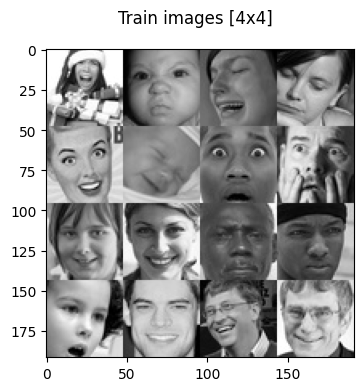

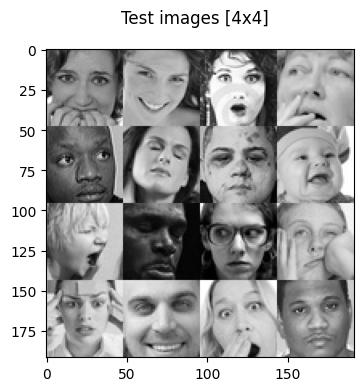

In [16]:
train_dl, val_dl, test_dl = load_data(Dataset_df, batch_sz=16)
train_images, _ = next(iter(train_dl))
test_images, _ = next(iter(test_dl))

show_batch(train_images, title="Train images", cols=4)
show_batch(test_images, title="Test images", cols=4)

In [17]:
import torch
import torch.nn as nn
from torchsummary import summary

def get_simple_conv_net():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Flatten(),
        nn.Linear(16 * 24 * 24, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model = get_simple_conv_net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


summary(model, input_size=(1, 48, 48))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             416
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
           Flatten-4                 [-1, 9216]               0
            Linear-5                  [-1, 128]       1,179,776
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 1,181,482
Trainable params: 1,181,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.71
Params size (MB): 4.51
Estimated Total Size (MB): 5.22
----------------------------------------------------------------


In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [19]:
def train_model_gpu_lr_conv(model, epochs, train_dl, optimiser, lr_scheduler):
    msg = ""
    for epoch in range(epochs):
        total_steps = len(train_dl)
        correct = 0
        total = 0

        model.train()
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(DEVICE)
            image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 48, 48)
            output = model(image_batch)
            losses = nn.CrossEntropyLoss()(output, label_batch)

            optimiser.zero_grad()
            losses.backward()
            optimiser.step()

            preds = torch.argmax(output, dim=1)
            correct += int(torch.eq(preds, label_batch).sum())
            total += batch_sz
            minibatch_accuracy = 100 * correct / total


            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps}], Loss: {losses.item():.5f}, Acc: {minibatch_accuracy:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)

        lr_scheduler.step()

In [20]:
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR

batch_sz = 16
learning_rate = 0.001
gamma = 0.8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 50


train_dl, val_dl, test_dl = load_data(Dataset_df, batch_sz=4)

network = get_simple_conv_net()
optim = SGD(network.parameters(), lr=learning_rate)
lr_sch = ExponentialLR(optim, gamma=gamma)
network = network.to(DEVICE)
train_model_gpu_lr_conv(network, epochs, train_dl, optim, lr_sch)


KeyboardInterrupt: 

In [25]:
import numpy as np

class EarlyStopper:
    def __init__(self, patience=1, tolerance=0):
       self.patience = patience
       self.tolerance = tolerance
       self.epoch_counter = 0
       self.max_validation_acc = np.NINF

    def should_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.epoch_counter = 0
        elif validation_acc < (self.max_validation_acc - self.tolerance):
            self.epoch_counter += 1
            if self.epoch_counter >= self.patience:
                return True
        return False

In [22]:
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter


In [23]:
import os

def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = f"{save_dir}/{filename}"
    torch.save(model.state_dict(), save_path)

In [29]:
def train_model_final(model,
                      epochs,
                      dataloaders,
                      optimiser,
                      lr_scheduler,
                      writer,
                      early_stopper,
                      checkpoint_frequency):
    msg = ""
    for epoch in range(epochs):

        model.train()
        train_dl = dataloaders['train']

        total_steps_train = len(train_dl)
        correct_train = 0
        total_train = 0
        loss_train = 0

        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(DEVICE)
            image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 48, 48)
            output = model(image_batch)
            loss_train = nn.CrossEntropyLoss()(output, label_batch)

            optimiser.zero_grad()
            loss_train.backward()
            optimiser.step()

            preds_train = torch.argmax(output, dim=1)
            correct_train += int(torch.eq(preds_train, label_batch).sum())
            total_train += batch_sz
            minibatch_accuracy_train = 100 * correct_train / total_train


            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_train}], Loss: {loss_train.item():.5f}, Acc: {minibatch_accuracy_train:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)

        print("")

        model.eval()  # set model to evaluation mode. This is very important, we do not want to update model weights in eval mode
        val_dl = dataloaders['val'] # select val dataloader

        total_steps_val = len(val_dl)
        correct_val = 0
        total_val = 0
        loss_val = 0

        for batch_num, (image_batch, label_batch) in enumerate(val_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(DEVICE)
            image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 48, 48)

            with torch.no_grad(): # no_grad disables gradient calculations, which are not needed when evaluating the model. This speeds up the calculations
                output = model(image_batch)
                loss_val = nn.CrossEntropyLoss()(output, label_batch)

                preds_val = torch.argmax(output, dim=1)
                correct_val += int(torch.eq(preds_val, label_batch).sum())
                total_val += batch_sz
                minibatch_accuracy_val = 100 * correct_val / total_val

                #### Fancy printing stuff, you can ignore this! ######
                if (batch_num + 1) % 5 == 0:
                    print(" " * len(msg), end='\r')
                    msg = f'Eval epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_val}], Loss: {loss_val.item():.5f}, Acc: {minibatch_accuracy_val:.5f}'
                    if early_stopper.epoch_counter > 0:
                        msg += f", Epochs without improvement: {early_stopper.epoch_counter}"
                    print (msg, end='\r' if epoch < epochs else "\n",flush=True)

        print("")


        epoch_train_acc = 100 * correct_train / total_train
        epoch_val_acc = 100 * correct_val / total_val

        writer.add_scalar('Loss/train', loss_train, epoch)
        writer.add_scalar('Loss/val', loss_val, epoch)
        writer.add_scalar('Acc/train', epoch_train_acc, epoch)
        writer.add_scalar('Acc/val', epoch_val_acc, epoch)
        lr_scheduler.step(loss_val)

        if epoch % checkpoint_frequency == 0:
            save_checkpoint(model, epoch, "./saved_models")

        if early_stopper.should_stop(epoch_val_acc):
            print(f"\nValidation accuracy has not improved in {early_stopper.epoch_counter} epochs, stopping.")
            save_checkpoint(model, epoch, "./saved_models")
            return

In [31]:
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

DATA_PATH = "DATASET_DIR"
batch_sz = 32
learning_rate = 0.001
gamma = 0.8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 15
checkpoint_frequency = 3


train_dl, val_dl, test_dl = load_data(Dataset_df, batch_sz=batch_sz)
dataloaders = {
    'train': train_dl,
    'val': val_dl,
    'test': test_dl
}

stopper = EarlyStopper(5, 0.001)
network = get_simple_conv_net()
network= network.to(DEVICE)
optim = SGD(network.parameters(), lr=learning_rate)
lr_sch = ExponentialLR(optim, gamma=gamma)


writer = SummaryWriter()


lr_scheduler = ReduceLROnPlateau(optim, patience=3, factor=0.1, verbose=True)

train_model_final(network, epochs, dataloaders, optim, lr_scheduler, writer, stopper, checkpoint_frequency)


Train epoch[1/15], MiniBatch[335/337], Loss: 1.77354, Acc: 23.71269
Eval epoch[1/15], MiniBatch[225/225], Loss: 1.79449, Acc: 23.12944 
Train epoch[2/15], MiniBatch[335/337], Loss: 1.64765, Acc: 30.40112
Eval epoch[2/15], MiniBatch[225/225], Loss: 2.21387, Acc: 22.32130 
Train epoch[3/15], MiniBatch[335/337], Loss: 1.60208, Acc: 36.85634
Eval epoch[3/15], MiniBatch[225/225], Loss: 1.87556, Acc: 31.25261, Epochs without improvement: 1
Train epoch[4/15], MiniBatch[335/337], Loss: 1.64009, Acc: 40.30784                              
Eval epoch[4/15], MiniBatch[225/225], Loss: 1.77478, Acc: 32.06075 
Train epoch[5/15], MiniBatch[335/337], Loss: 1.47442, Acc: 43.21828
Eval epoch[5/15], MiniBatch[225/225], Loss: 1.71835, Acc: 33.70489 
Train epoch[6/15], MiniBatch[335/337], Loss: 1.62800, Acc: 46.30597
Eval epoch[6/15], MiniBatch[225/225], Loss: 1.69265, Acc: 35.90637 
Train epoch[7/15], MiniBatch[335/337], Loss: 1.09969, Acc: 49.40299
Eval epoch[7/15], MiniBatch[225/225], Loss: 2.32811, Acc

In [ ]:
last_epoch = 10
checkpoint_file_path = f"./saved_models/checkpoint_{last_epoch}.pth"

# Check if the file exists before attempting to load it
if os.path.exists(checkpoint_file_path):
    loaded_net_state_dict = torch.load(checkpoint_file_path)
    # Rest of your code
    train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)
    dataloaders = {
        'train': train_dl,
        'val': val_dl,
        'test': test_dl
    }
    # Rest of your code
else:
    print(f"Checkpoint file for epoch {last_epoch} not found.")


In [ ]:
def test_model(model, dataloaders):
    model.eval()
    correct = 0
    total = 0

    test_dl = dataloaders['test']
    total_steps = len(test_dl)
    msg = ""
    for batch_num, (image_batch, label_batch) in enumerate(test_dl):
        batch_sz = len(image_batch)
        label_batch = label_batch.to(DEVICE)
        image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 28, 28)
        out = model(image_batch)
        preds = torch.argmax(out, dim=1)
        correct += int(torch.eq(preds, label_batch).sum())
        total += label_batch.shape[0]
        if (batch_num + 1) % 5 == 0:
            print(" " * len(msg), end='\r')
            msg = f'Testing batch[{batch_num + 1}/{total_steps}]'
            print (msg, end='\r' if batch_num < total_steps else "\n", flush=True)
    print(f"\nFinal test accuracy for {total} examples: {100 * correct/total:.5f}")

In [ ]:
import pytorch_lightning as pl
import torch

In [ ]:
class PlResNet(pl.LightningModule):
    def __init__(self, in_channels, outputs):
        super().__init__()
        # model arch goes here
        self.model = ResNet(in_channels, ResBlock, outputs)

    def forward(self, inp):
        return self.model.forward(inp)

    def configure_optimizers(self):
        return SGD(self.parameters(), lr=learning_rate)

    def training_step(self, batch, batch_idx):
        image_batch, label_batch = batch
        batch_sz = len(image_batch)
        label_batch = label_batch.to(DEVICE)
        image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 28, 28)
        output = model(image_batch)
        loss = nn.CrossEntropyLoss()(output, label_batch)


        preds_train = torch.argmax(output, dim=1)
        correct_train += int(torch.eq(preds_train, label_batch).sum())
        minibatch_accuracy_train = 100 * correct_train / batch_sz


    def validation_step(self, batch, batch_idx):
        pass

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
# define callbacks
# saves last-K checkpoints based on "global_step" metric
# make sure you log it inside your LightningModule
# NOTE: Talk a little bit about what callback functions are
checkpoint_callback = ...
early_stop_callback = ...

# train
trainer = ...
...

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

class MyLightningModel(pl.LightningModule):
    # ... Your LightningModule definition ...

# Define ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
    filepath='./saved_models/checkpoints/',
    monitor='val_loss',
    save_top_k=3,  # Save the top 3 models based on validation loss
    mode='min',    # 'min' means lower validation loss is better
)

# Define EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,      # Number of epochs with no improvement after which training will be stopped
    mode='min',      # 'min' means training will stop when the quantity monitored has stopped decreasing
    verbose=True,
)

# Create a Lightning Trainer with the callbacks
trainer = pl.Trainer(
    max_epochs=15,
    gpus=1,
    callbacks=[checkpoint_callback, early_stop_callback],
)

# Train the model
trainer.fit(lightning_model, train_dataloader, val_dataloader)
